In [1]:
import torch

import sys
sys.path.append('../flowmatching')

import lightning

from hydra import compose, initialize
from hydra.utils import instantiate

import matplotlib.pyplot as plt

We compose the config file:

In [2]:
with initialize(version_base=None, config_path="../flowmatching/"):
    cfg = compose(config_name="config")

lightning.seed_everything(cfg.seed)

Seed set to 42


42

Next, we instantiate the data module:

In [3]:
datamodule = instantiate(cfg.datamodule)
datamodule.setup(stage=None)

We plot a few batches of 2D points from the data distribution. These points were sampled with the `make_circles` function in `sklearn.datasets`:

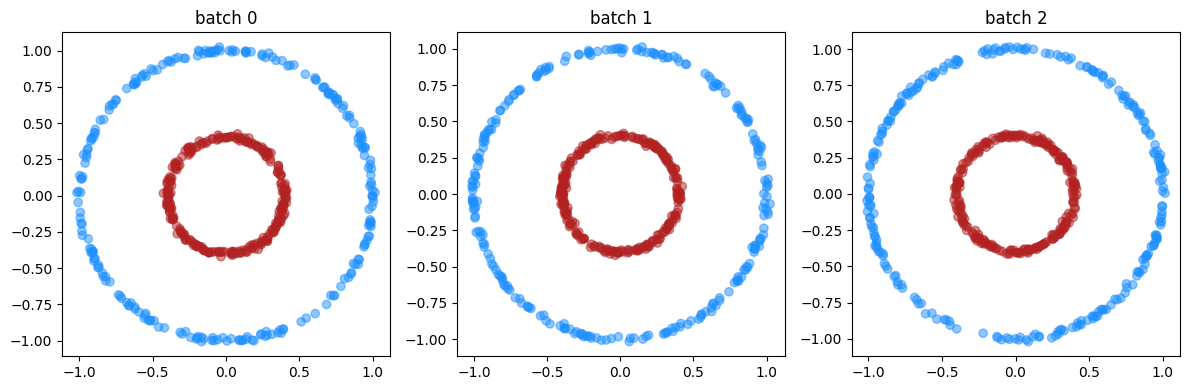

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

z, x = next(iter(datamodule.train_dataloader()))
_ = ax[0].scatter(z[:,0], z[:,1], alpha = 0.5,
                  c = ['dodgerblue' if label == 0 else 'firebrick' for label in x.squeeze()])
_ = ax[0].set_title("batch 0")
z, x = next(iter(datamodule.train_dataloader()))
_ = ax[1].scatter(z[:,0], z[:,1], alpha = 0.5,
                  c = ['dodgerblue' if label == 0 else 'firebrick' for label in x.squeeze()])
_ = ax[1].set_title("batch 1")
z, x = next(iter(datamodule.train_dataloader()))
_ = ax[2].scatter(z[:,0], z[:,1], alpha = 0.5,
                  c = ['dodgerblue' if label == 0 else 'firebrick' for label in x.squeeze()])
_ = ax[2].set_title("batch 2")

_ = fig.tight_layout()

Now we instantiate our flow matching module:

In [5]:
flowmodule = instantiate(cfg.flowmodule)

We load in the weights of a trained flow:

In [6]:
state_dict = torch.load("../trained_ckpts/circles.ckpt")['state_dict']
flowmodule.load_state_dict(state_dict)
flowmodule.eval()

FlowMatchingModule(
  (t_encoder): tEncoder(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=4, bias=True)
      (1): SiLU()
      (2): Linear(in_features=4, out_features=8, bias=True)
    )
  )
  (x_encoder): xEncoder(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1, out_features=2, bias=True)
    )
  )
  (velocity_net): VelocityNet(
    (net): Sequential(
      (0): Linear(in_features=12, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): SiLU()
      (6): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (loss): MSELoss()
)

And we sample a batch of 2D points from the trained flow, first using the Euler method and then using the midpoint method:

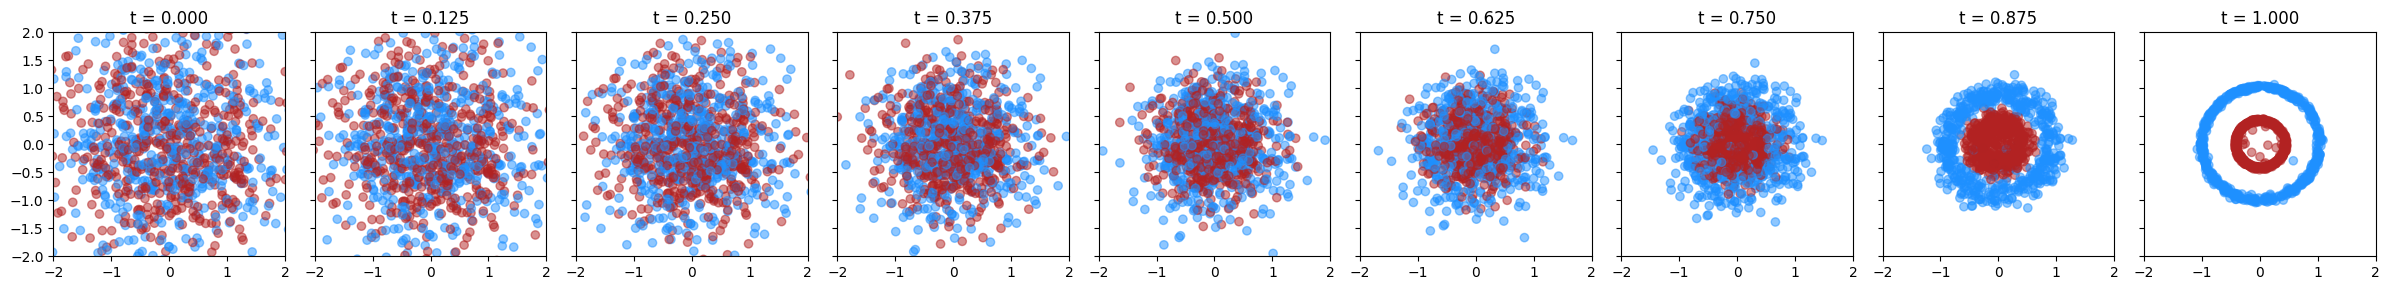

In [7]:
num_samples = 1024
num_time_steps = 8
t = torch.linspace(0.0, 1.0, num_time_steps + 1).view(-1, 1, 1).expand(-1, num_samples, 1)

fig, ax = plt.subplots(1, num_time_steps + 1, figsize = (num_time_steps * 3, 3), sharex = True, sharey = True)

z = torch.randn(num_samples, 2)
x = torch.randint(0, 2, [num_samples, 1], dtype = torch.float32)

_ = ax[0].scatter(z[:,0], z[:,1], alpha = 0.5,
                  c = ['dodgerblue' if label == 0 else 'firebrick' for label in x.squeeze()])
_ = ax[0].set_title(f't = {t[0].unique().item():.3f}')
_ = ax[0].set_xlim(-2, 2)
_ = ax[0].set_ylim(-2, 2)

for i in range(num_time_steps):
    with torch.no_grad():
        z = flowmodule.sample_path(z, x, t[i], t[i+1], method='midpoint')
    _ = ax[i+1].scatter(z[:,0], z[:,1], alpha = 0.5,
                        c = ['dodgerblue' if label == 0 else 'firebrick' for label in x.squeeze()])
    _ = ax[i+1].set_title(f't = {t[i+1].unique().item():.3f}')
    _ = ax[i+1].set_xlim(-2, 2)
    _ = ax[i+1].set_ylim(-2, 2)

_ = fig.tight_layout()